In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib
import yfinance as yf

# 행(row) 다 보기
pd.set_option('display.max_rows', None)

# 열(column) 다 보기
pd.set_option('display.max_columns', None)

In [2]:
pd.set_option('display.max_columns', None)
from PublicDataReader import Ecos

service_key = "2G5XUDEN750MGRZM37GF"
api = Ecos(service_key)
df = api.get_statistic_table_list()
df.head()

,상위통계표코드,통계표코드,통계명,시점,검색가능여부,출처
0,*,0000000001,1. 통화/금융,None,N,None
1,0000000001,0000000002,1.1. 통화/유동성,None,N,None
2,0000000002,0000000003,1.1.1. 본원통화,None,N,None
3,0000000003,0000000004,1.1.1.1. 본원통화 구성내역,None,N,None
4,0000000004,102Y004,"1.1.1.1.1. 본원통화 구성내역(평잔, 계절조정계열)",M,Y,None


### 금리차

- 기준금리차 = 시중 대출금리 − 한국은행 기준금리
- 일반적으로 은행은 대출금리 > 기준금리 (스프레드)
- 스프레드 = 은행 수익 + 자금조달 비용 + 신용위험 프리미엄


- 스프레드 확대
    + 은행이 대출 위험을 더 반영하거나 자금 조달 비용이 증가 → 기업/가계 부담 ↑, 소비/투자 둔화 가능
- 스프레드 축소
    + 은행 경쟁 심화, 자금조달 비용 감소 → 대출금리 낮아짐 → 소비/투자 촉진 가능
- 차이가 벌어짐 + 대출금리 상승
    + 금융 여건 긴축 신호, 경기 둔화 가능성
- 차이가 벌어짐 + 대출금리 하락 느림
    + 정책 효과(기준금리 인하)가 시중금리에 완전히 반영되지 않음 → 경기 부양 효과 제한


In [34]:
df_kor_rate = api.get_statistic_search(통계표코드="722Y001", 주기="M", 검색시작일자="201901", 검색종료일자="202510")
df_bank_rate = api.get_statistic_search(통계표코드="121Y006", 주기="M", 검색시작일자="201901", 검색종료일자="202510")

df_kor_rate = df_kor_rate[df_kor_rate['통계항목명1'] == '한국은행 기준금리'][['통계항목명1', '시점', '값']]
df_bank_rate = df_bank_rate[df_bank_rate['통계항목명1'].isin(['기업대출', '가계대출', '주택담보대출'])][['통계항목명1', '시점', '값']]

df_rate = pd.concat([df_kor_rate, df_bank_rate])
df_rate['값'] = df_rate['값'].astype(float)


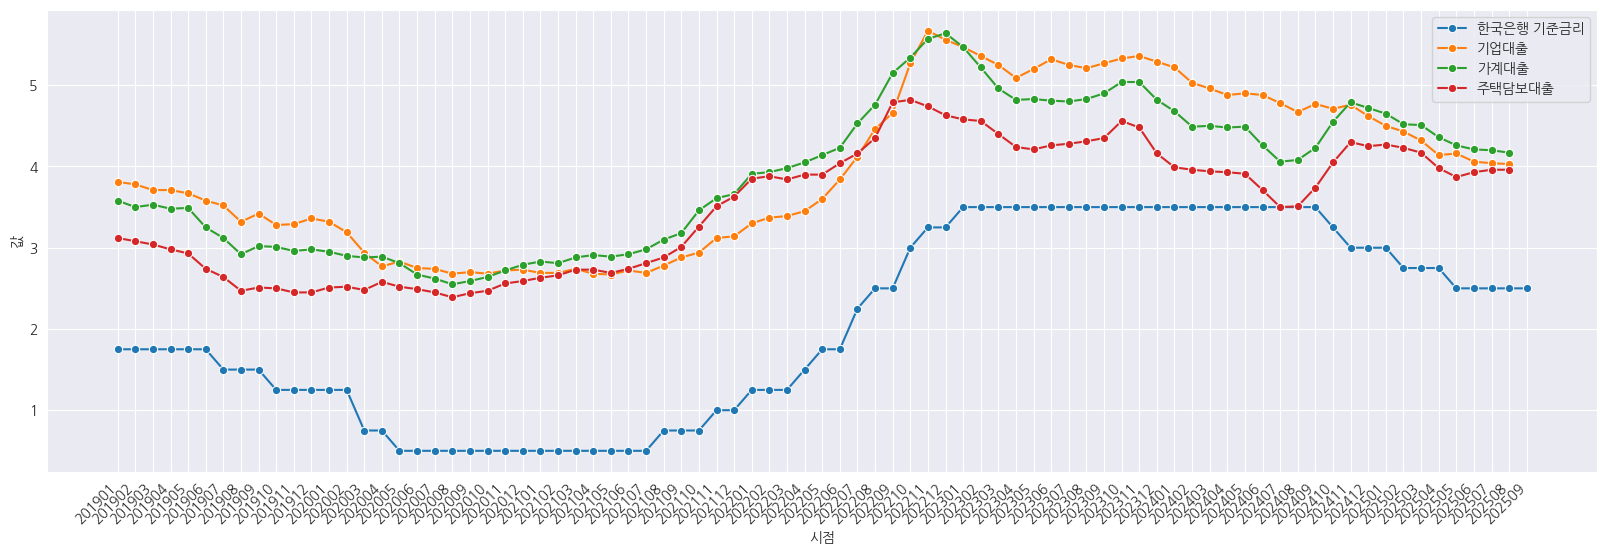

In [35]:
plt.figure(figsize=(20,6))  # 그림 넓게
sns.lineplot(x="시점", y="값", data=df_rate, hue='통계항목명1', marker='o')

# x축 레이블 회전
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

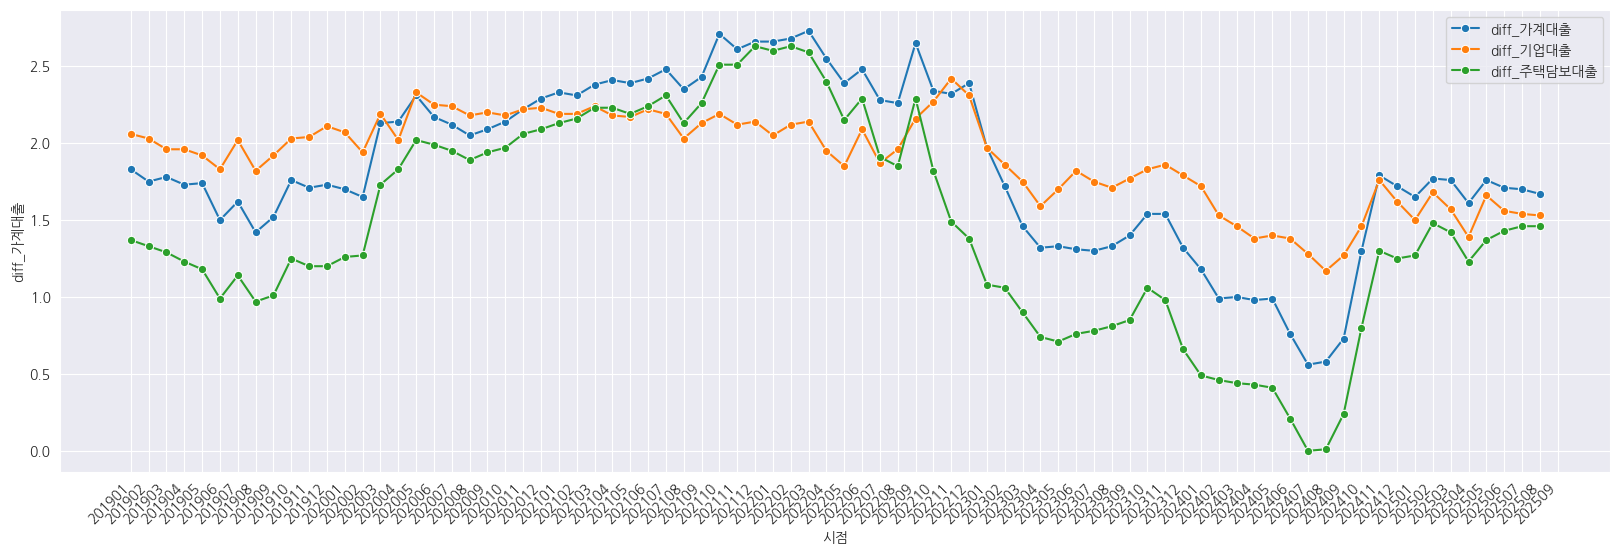

In [36]:
df_tmp = pd.pivot(data=df_rate, index='시점', columns='통계항목명1', values='값')
df_tmp['diff_가계대출'] = df_tmp['가계대출'] - df_tmp['한국은행 기준금리']
df_tmp['diff_기업대출'] = df_tmp['기업대출'] - df_tmp['한국은행 기준금리']
df_tmp['diff_주택담보대출'] = df_tmp['주택담보대출'] - df_tmp['한국은행 기준금리']

plt.figure(figsize=(20,6))  # 그림 넓게
sns.lineplot(x=df_tmp.index, y=df_tmp["diff_가계대출"], marker='o', label=['diff_가계대출'])
sns.lineplot(x=df_tmp.index, y=df_tmp["diff_기업대출"], marker='o', label=['diff_기업대출'])
sns.lineplot(x=df_tmp.index, y=df_tmp["diff_주택담보대출"], marker='o', label=['diff_주택담보대출'])

# x축 레이블 회전
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

### M2(광의통화)

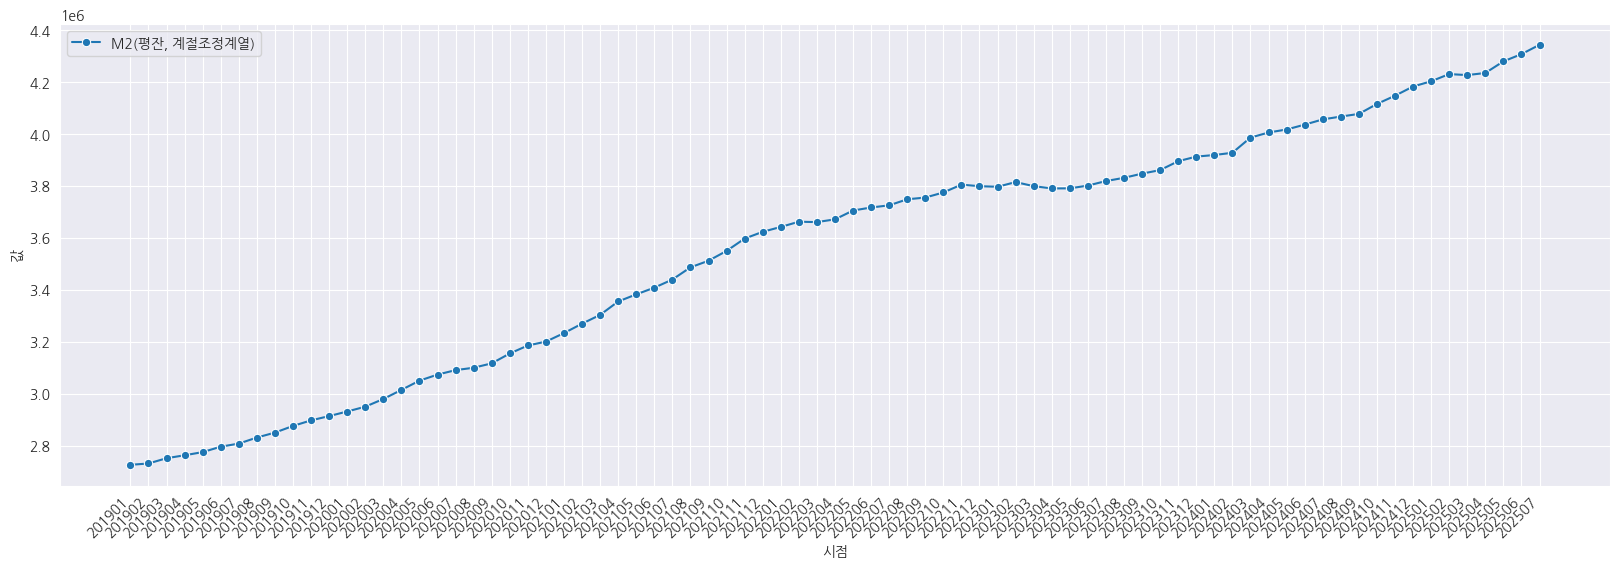

In [59]:
df_m2 = api.get_statistic_search(통계표코드="101Y003", 주기="M", 검색시작일자="201901", 검색종료일자="202510")
df_m2['값'] = df_m2['값'].astype(float)

plt.figure(figsize=(20,6))  # 그림 넓게
sns.lineplot(x="시점", y="값", data=df_m2[df_m2['통계항목명1'] == 'M2(평잔, 계절조정계열)'], hue='통계항목명1', marker='o')

# x축 레이블 회전
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

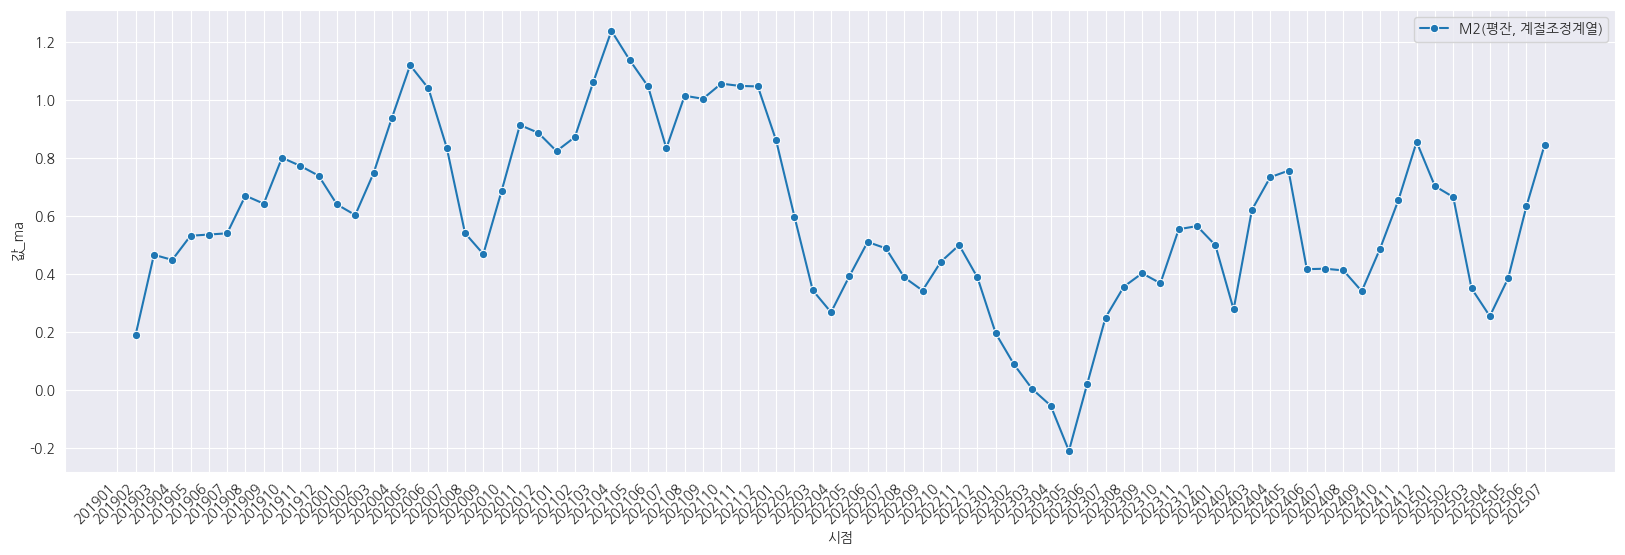

In [51]:
df_tmp = df_m2[df_m2['통계항목명1'] == 'M2(평잔, 계절조정계열)'].copy()
df_tmp['값_prev'] = df_tmp['값'].shift(1)
df_tmp['값_ratio'] = ((df_tmp['값'] / df_tmp['값_prev']) - 1) * 100
df_tmp['값_ma'] = df_tmp['값_ratio'].rolling(window=3, min_periods=1).mean()

plt.figure(figsize=(20,6))  # 그림 넓게
sns.lineplot(x="시점", y="값_ma", data=df_tmp, hue='통계항목명1', marker='o')

# x축 레이블 회전
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

In [66]:
df_m2_tot = df_m2[df_m2['통계항목명1'] == 'M2(평잔, 계절조정계열)'][['시점','값']].rename(columns={'값':'tot'}).copy()
df_m2_else = df_m2[df_m2['통계항목명1'] != 'M2(평잔, 계절조정계열)'].copy()

df_m2_comp = df_m2_else.merge(df_m2_tot, on='시점')
df_m2_comp['ratio'] = np.round((df_m2_comp['값'] / df_m2_comp['tot']), 2) * 100
df_m2_comp.head()

,통계표코드,통계명,통계항목코드1,통계항목명1,통계항목코드2,통계항목명2,통계항목코드3,통계항목명3,통계항목코드4,통계항목명4,단위,WGT,시점,값,tot,ratio
0,101Y003,"1.1.3.1.1. M2 상품별 구성내역(평잔, 계절조정계열)",BBHS01,현금통화,None,None,None,None,None,None,십억원,None,201901,104631.0,2726097.6,4.0
1,101Y003,"1.1.3.1.1. M2 상품별 구성내역(평잔, 계절조정계열)",BBHS02,요구불예금,None,None,None,None,None,None,십억원,None,201901,228243.7,2726097.6,8.0
2,101Y003,"1.1.3.1.1. M2 상품별 구성내역(평잔, 계절조정계열)",BBHS03,수시입출식저축성예금,None,None,None,None,None,None,십억원,None,201901,518377.3,2726097.6,19.0
3,101Y003,"1.1.3.1.1. M2 상품별 구성내역(평잔, 계절조정계열)",BBHS04,MMF,None,None,None,None,None,None,십억원,None,201901,75522.0,2726097.6,3.0
4,101Y003,"1.1.3.1.1. M2 상품별 구성내역(평잔, 계절조정계열)",BBHS05,만기2년미만정기예적금,None,None,None,None,None,None,십억원,None,201901,1101311.3,2726097.6,40.0


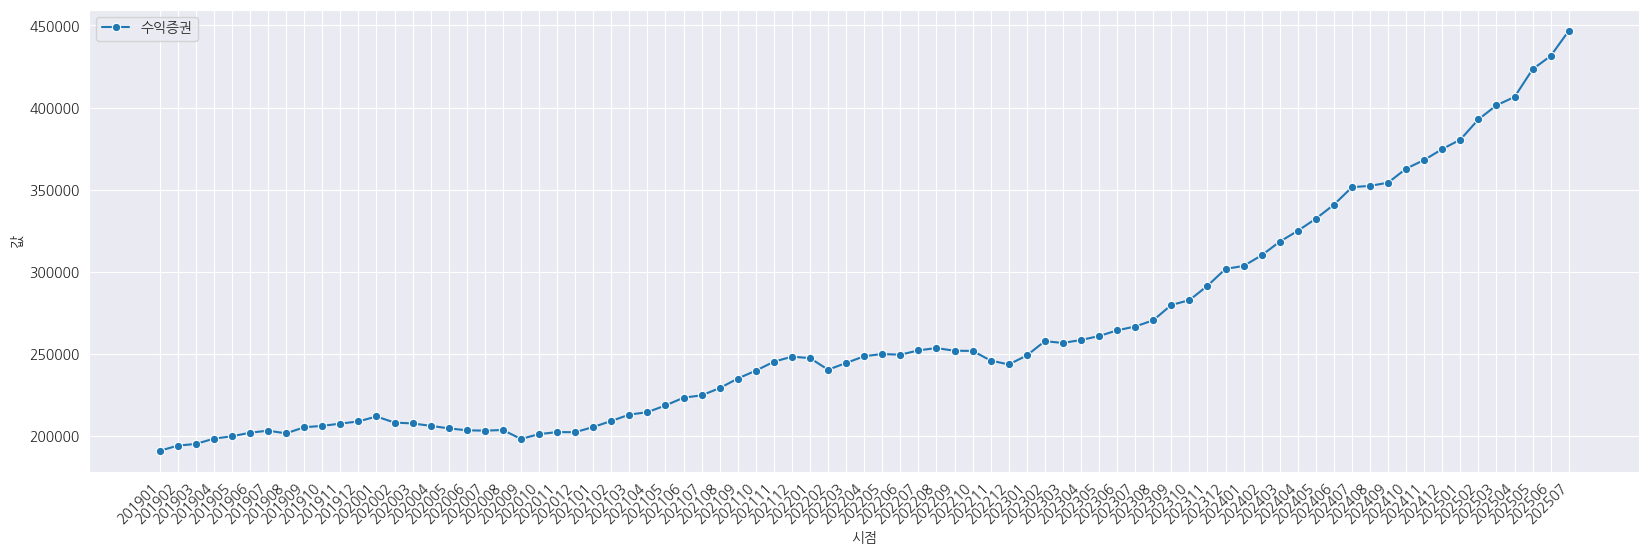

In [72]:
plt.figure(figsize=(20,6))  # 그림 넓게
sns.lineplot(x="시점", y="값",
             data=df_m2_comp[df_m2_comp['통계항목명1'].isin([ '수익증권'])],
             hue='통계항목명1', marker='o')

# x축 레이블 회전
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

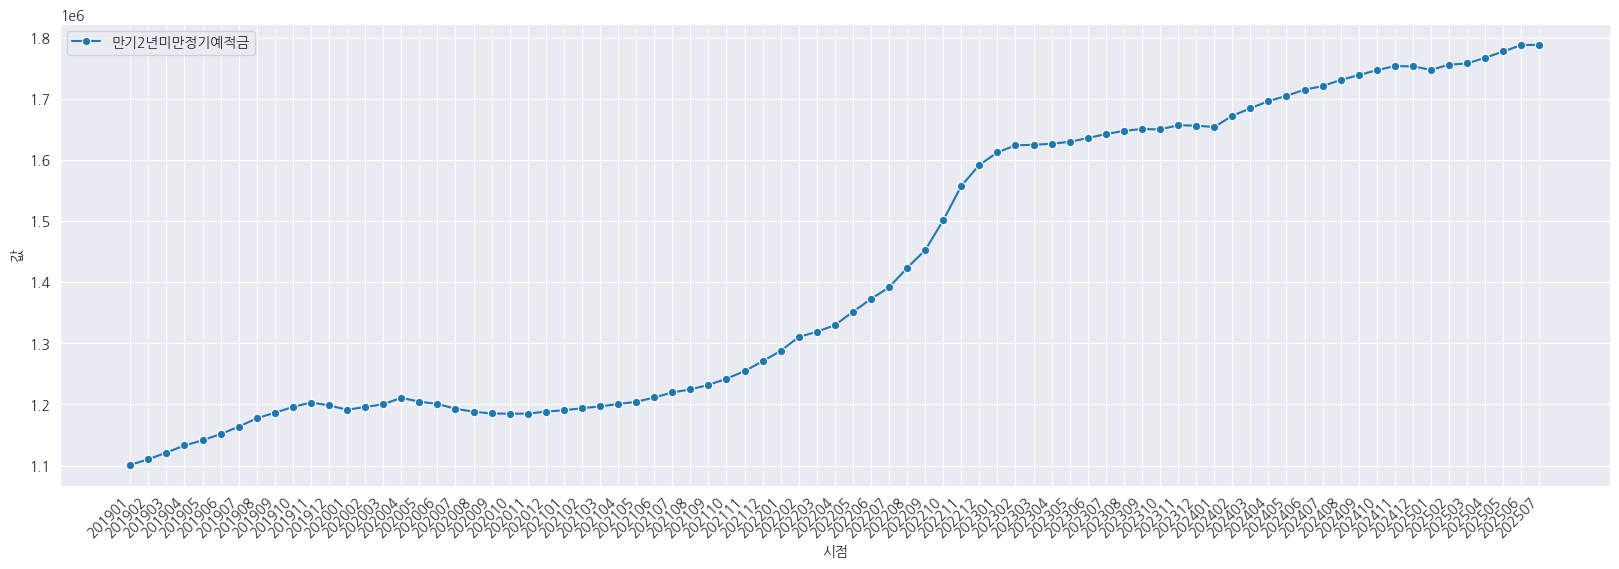

In [73]:
plt.figure(figsize=(20,6))  # 그림 넓게
sns.lineplot(x="시점", y="값",
             data=df_m2_comp[df_m2_comp['통계항목명1'].isin([ '만기2년미만정기예적금'])],
             hue='통계항목명1', marker='o')

# x축 레이블 회전
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

- 금리차

In [6]:
df_idx = yf.download(["^GSPC", "^KS11", "^FVX", "^TNX", "^TYX"], start='2010-01-01', end='2025-10-01', auto_adjust=True)

df_idx = df_idx[[( 'Close', '^GSPC'), ( 'Close', '^KS11'), ( 'Close', '^FVX'), ( 'Close', '^TNX'), ( 'Close', '^TYX')]]
df_idx = df_idx.dropna()
df_idx.columns = ['_'.join(col).strip() for col in df_idx.columns.values]

df_idx['diff_30_5'] = df_idx['Close_^TYX'] - df_idx['Close_^FVX']

df_idx.head()

[*********************100%***********************]  5 of 5 completed


,Close_^GSPC,Close_^KS11,Close_^FVX,Close_^TNX,Close_^TYX,diff_30_5
Date,,,,,,
2010-01-04,1132.989990,1696.140015,2.652,3.841,4.660,2.008
2010-01-05,1136.520020,1690.619995,2.558,3.755,4.593,2.035
2010-01-06,1137.140015,1705.319946,2.573,3.808,4.671,2.098
2010-01-07,1141.689941,1683.449951,2.600,3.822,4.689,2.089
2010-01-08,1144.979980,1695.260010,2.566,3.808,4.695,2.129


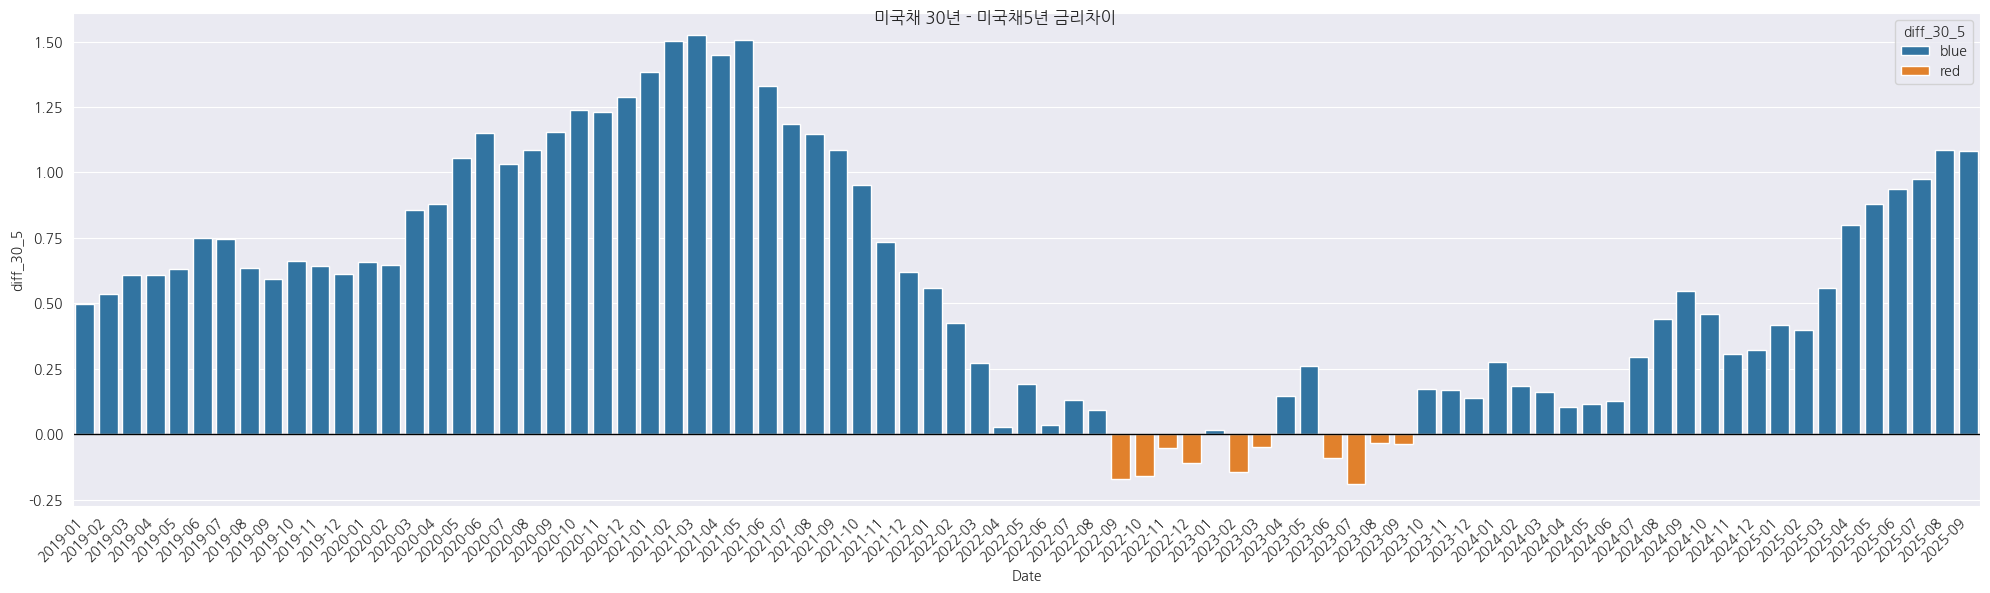

In [7]:
plt.figure(figsize=(20,6))
df_monthly = df_idx.resample('ME').mean()   # 월 평균
df_monthly = df_monthly[df_monthly.index > '2019-01-01']
colors = df_monthly['diff_30_5'].apply(lambda x: 'red' if x < 0 else 'blue')
sns.barplot(x=df_monthly.index.strftime('%Y-%m'), y=df_monthly["diff_30_5"],  hue=colors)

# x축 레이블 회전
plt.axhline(0, color='black', linewidth=1)  # 0 기준선 추가
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.suptitle('미국채 30년 - 미국채5년 금리차이')
plt.show()

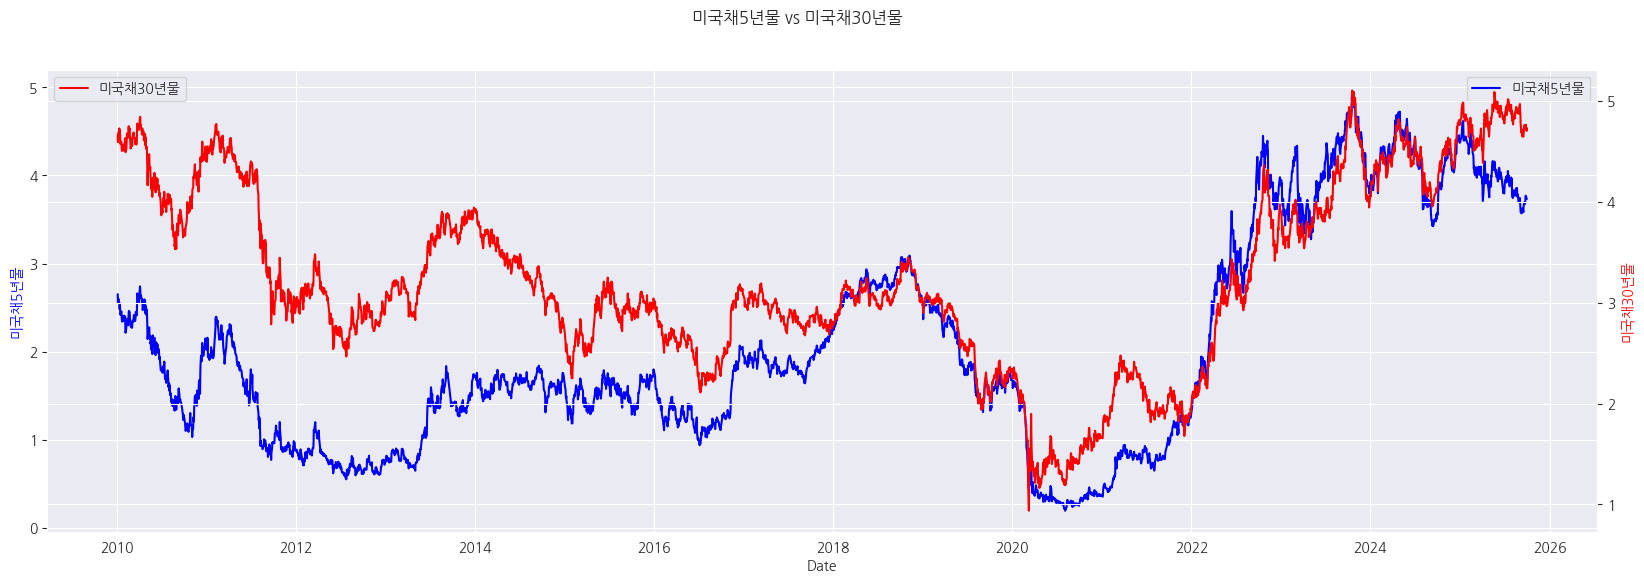

In [8]:
fig, ax1 = plt.subplots(figsize=(20,6))
sns.lineplot(x=df_idx.index, y=df_idx["Close_^FVX"], ax=ax1, label="미국채5년물", color='blue')
ax1.set_ylabel('미국채5년물', color='blue')

ax2 = ax1.twinx()
sns.lineplot(x=df_idx.index, y=df_idx["Close_^TYX"], ax=ax2, label="미국채30년물", color='red')
ax2.set_ylabel('미국채30년물', color='red')

fig.suptitle('미국채5년물 vs 미국채30년물')
plt.show()

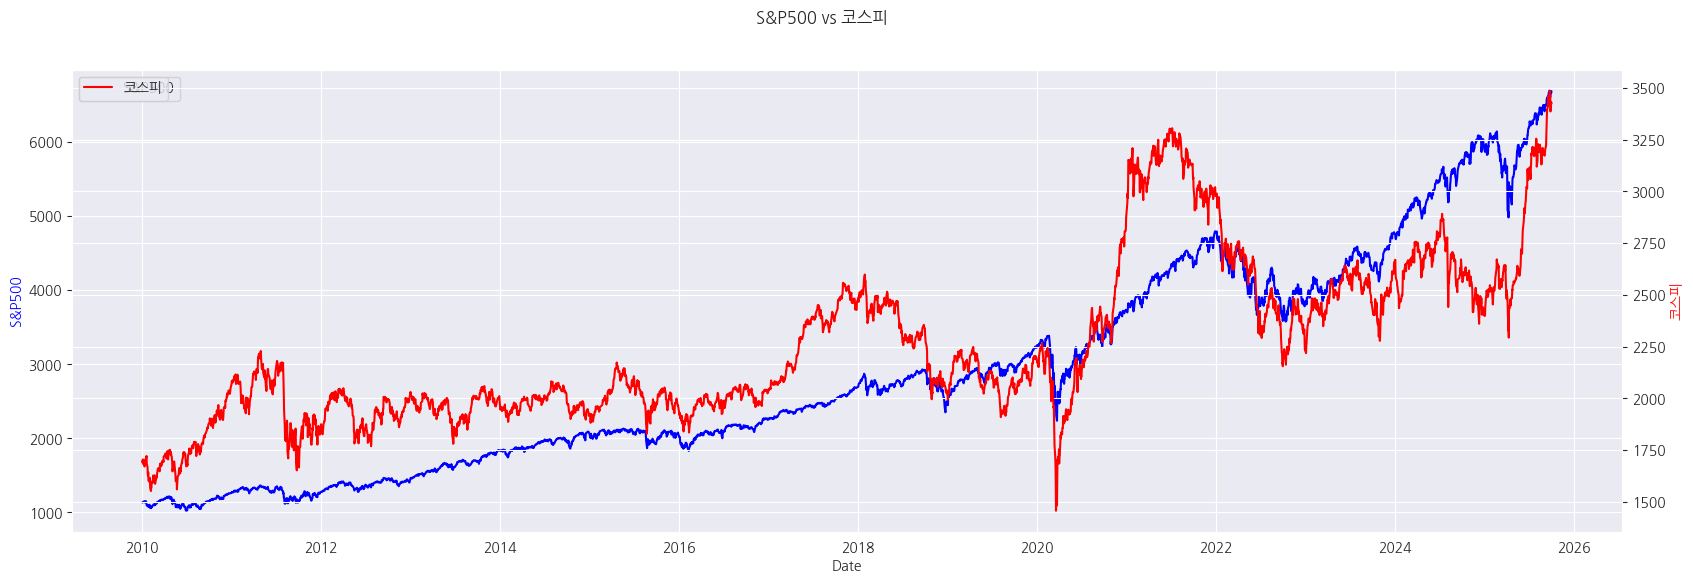

In [9]:
fig, ax1 = plt.subplots(figsize=(20,6))
sns.lineplot(x=df_idx.index, y=df_idx["Close_^GSPC"], ax=ax1, label="S&P500", color='blue')
ax1.set_ylabel('S&P500', color='blue')

ax2 = ax1.twinx()
sns.lineplot(x=df_idx.index, y=df_idx["Close_^KS11"], ax=ax2, label="코스피", color='red')
ax2.set_ylabel('코스피', color='red')

fig.suptitle('S&P500 vs 코스피')
plt.show()

- 세리계 금리



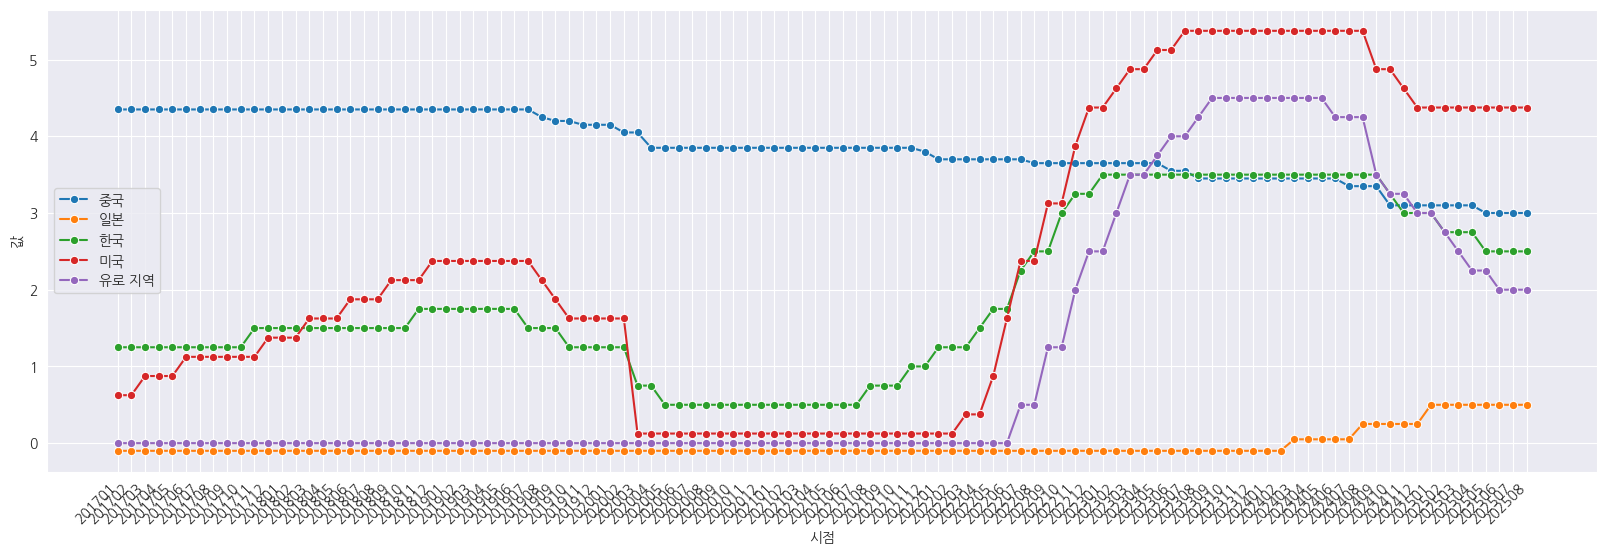

In [12]:
### 외환수급
from PublicDataReader import Ecos

service_key = "2G5XUDEN750MGRZM37GF"
api = Ecos(service_key)
df = api.get_statistic_table_list()

df_foreign_money = api.get_statistic_search(통계표코드="902Y006", 주기="M", 검색시작일자="201701", 검색종료일자="202510")
df_foreign_money['값'] = df_foreign_money['값'].astype(float)

df_foreign_money = df_foreign_money[df_foreign_money['통계항목명1'].isin(['미국', '유로 지역', '일본', '중국', '한국'])]


plt.figure(figsize=(20,6))  # 그림 넓게
sns.lineplot(x="시점", y="값",
             data=df_foreign_money,
             hue='통계항목명1', marker='o')


# x축 레이블 회전
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()